## Titanic Data Exploration

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

In [2]:
train.groupby('Pclass')['Fare'].describe()

,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,216.0,84.154687,78.380373,0.0,30.92395,60.2875,93.5,512.3292
2,184.0,20.662183,13.417399,0.0,13.00000,14.2500,26.0,73.5000
3,491.0,13.675550,11.778142,0.0,7.75000,8.0500,15.5,69.5500


In [3]:
train['Embarked'].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

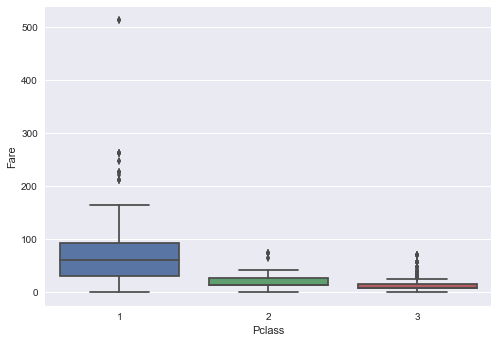

In [11]:
plt.figure(1)
sns.boxplot(x='Pclass', y='Fare', data=train)
plt.show()

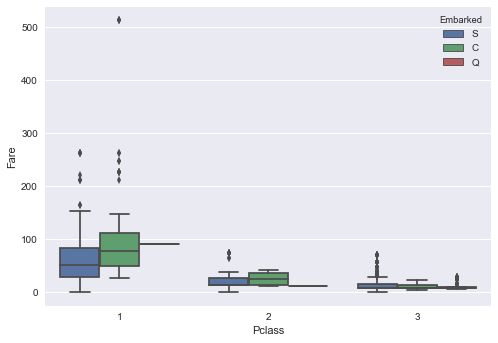

In [19]:
plt.figure(2)
sns.boxplot(x='Pclass', y='Fare', hue='Embarked', data=train)
plt.show()

In [20]:
train[train['Embarked'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [21]:
train[train['Cabin'] == 'B28']

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [28]:
train.loc[train['Ticket'].str.contains('113'), ['Ticket', 'Pclass', 'Fare', 'Embarked']]

,Ticket,Pclass,Fare,Embarked
PassengerId,,,,
4,113803,1,53.1000,S
12,113783,1,26.5500,S
24,113788,1,35.5000,S
36,113789,1,52.0000,S
55,113509,1,61.9792,C
62,113572,1,80.0000,NaN
84,113059,1,47.1000,S
138,113803,1,53.1000,S
152,113776,1,66.6000,S
